# Project

To Develop a predictive model using Python Modeller to automatically notify AHG leaders 90 days before a customer is due to churn, i e when a customer’s churn propensity exceeds a specific threshold, say 0 7

### Import all the necessary Libraries for this project

In [186]:
%matplotlib inline
import datetime as dt
import pylab
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# data colelction and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression

In [187]:
#Create a connection from Python to SQL
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-T3PQE3U;"
                      "Database=AdventureWorksDW2017;"
                      "Trusted_Connection=yes;")

# Import all the required tables from SQL Server DW

In [188]:
#Import Factinternetsales from AHG SQL Datawarehouse
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[OrderQuantity]
,[SalesAmount]
,[OrderDate]
,[SalesTerritoryKey]
,[SalesOrderNumber]
,[UnitPrice]
FROM [dbo].[FactInternetSales]""", cnxn)

In [189]:
#Its a good practive to visualise the newly created datasets
fctintsales.head()

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey,SalesOrderNumber,UnitPrice
0,21768,1,3578.2700,2010-12-29,6,SO43697,3578.2700
1,28389,1,3399.9900,2010-12-29,7,SO43698,3399.9900
2,25863,1,3399.9900,2010-12-29,1,SO43699,3399.9900
3,14501,1,699.0982,2010-12-29,4,SO43700,699.0982
4,11003,1,3399.9900,2010-12-29,9,SO43701,3399.9900


In [190]:
fctintsales.dtypes

CustomerKey                   int64
OrderQuantity                 int64
SalesAmount                 float64
OrderDate            datetime64[ns]
SalesTerritoryKey             int64
SalesOrderNumber             object
UnitPrice                   float64
dtype: object

In [191]:
#Import Customer Table SQL datawarehouse using the existing connections
custtbl = pd.read_sql_query("""
SELECT
[CustomerKey]
,[BirthDate]
,[MaritalStatus]
,[Gender]
,[YearlyIncome]
,[TotalChildren]
,[NumberChildrenAtHome]
,[EnglishEducation]
,[EnglishOccupation]
,[HouseOwnerFlag]
,[NumberCarsOwned]
,[DateFirstPurchase]
,[CommuteDistance]
FROM [dbo].[DimCustomer]""", cnxn)

In [192]:
#Its a good practive to visualise the newly created datasets using .head() function
# .dytpes function will return the datatypes

custtbl.head(5)
#custtbl.dtypes

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [193]:
custtbl.dtypes

CustomerKey               int64
BirthDate                object
MaritalStatus            object
Gender                   object
YearlyIncome            float64
TotalChildren             int64
NumberChildrenAtHome      int64
EnglishEducation         object
EnglishOccupation        object
HouseOwnerFlag           object
NumberCarsOwned           int64
DateFirstPurchase        object
CommuteDistance          object
dtype: object

In [194]:
#Import Factinternetsalesreason from SQL Datawarehouse
fctinsalesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]""", cnxn)

In [195]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
fctinsalesreason.head(5)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey
0,SO43697,1,5
1,SO43697,1,9
2,SO43702,1,5
3,SO43702,1,9
4,SO43703,1,5


In [196]:
#Import salesreason from SQL Datawarehouse
salesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]""", cnxn)

In [197]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
salesreason.head(20)

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other
5,6,6,Review,Other
6,7,7,Demo Event,Marketing
7,8,8,Sponsorship,Marketing
8,9,9,Quality,Other
9,10,10,Other,Other


### Summarise customer transactions and tag customers based on the churn criteria given (8 months above)

In [198]:
fctintsales[fctintsales['CustomerKey'] == 11000]

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey,SalesOrderNumber,UnitPrice
96,11000,1,3399.99,2011-01-19,9,SO43793,3399.99
6396,11000,1,2319.99,2013-01-18,9,SO51522,2319.99
6397,11000,1,21.98,2013-01-18,9,SO51522,21.98
19223,11000,1,2384.07,2013-05-03,9,SO57418,2384.07
19224,11000,1,28.99,2013-05-03,9,SO57418,28.99
19225,11000,1,4.99,2013-05-03,9,SO57418,4.99
19226,11000,1,34.99,2013-05-03,9,SO57418,34.99
19227,11000,1,53.99,2013-05-03,9,SO57418,53.99


For us to get the churnners and returned it is very important we prepare our fact internet sales data by getting the time between various orders, group it by sales order number, customer key and order date and aggregate it by the sum of sales amount and order quantity thereafter we drive the date difference.

In [199]:
#Let get time between various orders
Timebtworders = fctintsales #Asign fctintsales to enable us pick out the needed columns
Timebtworders = Timebtworders[['SalesOrderNumber','CustomerKey','OrderDate','SalesAmount','OrderQuantity','UnitPrice']]


In [200]:
#Group the time between various orders by sales order number, customerkey and orderdate aggregate by sum
#order quantity and sales amount
Timebtworders = Timebtworders.groupby(['SalesOrderNumber','CustomerKey','OrderDate','UnitPrice']).agg({'SalesAmount':'sum', 
                         'OrderQuantity':'sum'})

In [201]:
#Display the new table 
Timebtworders.head(5)

,,,,SalesAmount,OrderQuantity
SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,,
SO43697,21768,2010-12-29,3578.2700,3578.2700,1
SO43698,28389,2010-12-29,3399.9900,3399.9900,1
SO43699,25863,2010-12-29,3399.9900,3399.9900,1
SO43700,14501,2010-12-29,699.0982,699.0982,1
SO43701,11003,2010-12-29,3399.9900,3399.9900,1


In [202]:
#Join the field names to the newly aggregate fields names
Timebtworders.columns = Timebtworders.columns.ravel()

In [203]:
#Reset the index
Timebtworders = Timebtworders.reset_index()

In [204]:
Timebtworders[Timebtworders['CustomerKey'] == 11000]

,SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,3399.99,1
6389,SO51522,11000,2013-01-18,21.98,21.98,1
6390,SO51522,11000,2013-01-18,2319.99,2319.99,1
19118,SO57418,11000,2013-05-03,4.99,4.99,1
19119,SO57418,11000,2013-05-03,28.99,28.99,1
19120,SO57418,11000,2013-05-03,34.99,34.99,1
19121,SO57418,11000,2013-05-03,53.99,53.99,1
19122,SO57418,11000,2013-05-03,2384.07,2384.07,1


From the result of the above code you could see differece in the order quantity for various order numbers and date  

In [205]:
#Lets sort by customerkey and order date for easy arrangement
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,3399.99,1
6389,SO51522,11000,2013-01-18,21.98,21.98,1
6390,SO51522,11000,2013-01-18,2319.99,2319.99,1
19118,SO57418,11000,2013-05-03,4.99,4.99,1
19119,SO57418,11000,2013-05-03,28.99,28.99,1


In [206]:
#Lets get the difference in the order date for every customer
Timebtworders['diff'] = Timebtworders.sort_values(['CustomerKey','OrderDate']).groupby('CustomerKey')['OrderDate'].diff()

In [207]:
#Display the table to show the difference in date
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,3399.99,1,NaT
6389,SO51522,11000,2013-01-18,21.98,21.98,1,730 days
6390,SO51522,11000,2013-01-18,2319.99,2319.99,1,0 days
19118,SO57418,11000,2013-05-03,4.99,4.99,1,105 days
19119,SO57418,11000,2013-05-03,28.99,28.99,1,0 days


From the out put above you could see that the 'Diff" is not in the right structure lets convert it properly to float for easy calculation.

In [208]:
#lets specify the dtypes to timedelta64[D] for days
Timebtworders['diff'] = Timebtworders['diff'].astype('timedelta64[D]')

In [209]:
#Display the result
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,3399.99,1,NaN
6389,SO51522,11000,2013-01-18,21.98,21.98,1,730.0
6390,SO51522,11000,2013-01-18,2319.99,2319.99,1,0.0
19118,SO57418,11000,2013-05-03,4.99,4.99,1,105.0
19119,SO57418,11000,2013-05-03,28.99,28.99,1,0.0


In [210]:
#Let see the data types we have before we can proceed 
Timebtworders.dtypes

SalesOrderNumber            object
CustomerKey                  int64
OrderDate           datetime64[ns]
UnitPrice                  float64
SalesAmount                float64
OrderQuantity                int64
diff                       float64
dtype: object

In [211]:
Timebtworders['diff'] = Timebtworders['diff'].fillna(0).astype(int) #Replace Na with 0 to enable uniformity in the column

In [212]:
Timebtworders.sort_values(['CustomerKey','OrderDate']).head() #Display the outcome

,SalesOrderNumber,CustomerKey,OrderDate,UnitPrice,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,3399.99,1,0
6389,SO51522,11000,2013-01-18,21.98,21.98,1,730
6390,SO51522,11000,2013-01-18,2319.99,2319.99,1,0
19118,SO57418,11000,2013-05-03,4.99,4.99,1,105
19119,SO57418,11000,2013-05-03,28.99,28.99,1,0


The Diff column has changed to all integer making it ready for use

Let group the sum, max, min, mean and median for SalesAmount, OrderQuantity, OrderDate and diff for every customerKey

In [213]:
new_fctintsales = Timebtworders.groupby('CustomerKey').agg({'SalesAmount':['sum', 'max', 'min','mean','median'], 
                         'OrderQuantity':['sum', 'max', 'min','mean','median'], 
                         'OrderDate':'max','diff':['sum', 'max', 'min','mean','median']})

In [214]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
new_fctintsales.head(5)

SalesAmount                                       OrderQuantity  \
                    sum      max    min         mean   median           sum   
CustomerKey                                                                   
11000           8248.99  3399.99   4.99  1031.123750    44.49             8   
11001           6383.88  3374.99   4.99   580.352727    21.98            11   
11002           8114.04  3399.99  34.99  2028.510000  2339.53             4   
11003           8139.29  3399.99   2.29   904.365556     9.99             9   
11004           8196.01  3399.99  21.98  1366.001667  1177.49             6   

                                 OrderDate  diff                              
            max min mean median        max   sum  max min        mean median  
CustomerKey                                                                   
11000         1   1  1.0    1.0 2013-05-03   835  730   0  104.375000    0.0  
11001         1   1  1.0    1.0 2013-12-10  1060  732   0   96.363636    0.0  
11002         1   1  1.0    1.0 2013-02-23   778  724   0  194.500000   27.0  
11003         1   1  1.0    1.0 2013-05-10   863  738   0   95.888889    0.0  
11004         1   1  1.0    1.0 2013-05-01   829  730   0  138.166667    0.0

From the result above, the minimume quantity purcahsed by each customer is 1 and the last purcahse date clearly showing under maximume orderdate. 

In [215]:
#Join the field names to the newly aggregate fields names
new_fctintsales.columns = ["_".join(new_fctintsales) for new_fctintsales in new_fctintsales.columns.ravel()]

In [216]:
#Reset the index
new_fctintsales = new_fctintsales.reset_index()

In [217]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
new_fctintsales.head(10)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median
0,11000,8248.99,3399.99,4.99,1031.123750,44.490,8,1,1,1.0,1.0,2013-05-03,835,730,0,104.375000,0.0
1,11001,6383.88,3374.99,4.99,580.352727,21.980,11,1,1,1.0,1.0,2013-12-10,1060,732,0,96.363636,0.0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.530,4,1,1,1.0,1.0,2013-02-23,778,724,0,194.500000,27.0
3,11003,8139.29,3399.99,2.29,904.365556,9.990,9,1,1,1.0,1.0,2013-05-10,863,738,0,95.888889,0.0
4,11004,8196.01,3399.99,21.98,1366.001667,1177.490,6,1,1,1.0,1.0,2013-05-01,829,730,0,138.166667,0.0
5,11005,8121.33,3374.99,2.29,1353.555000,1177.495,6,1,1,1.0,1.0,2013-05-02,854,755,0,142.333333,0.0
6,11006,8119.03,3399.99,4.99,1623.806000,2319.990,5,1,1,1.0,1.0,2013-05-14,841,705,0,168.200000,0.0
7,11007,8211.00,3399.99,4.99,1026.375000,34.995,8,1,1,1.0,1.0,2013-03-19,800,743,0,100.000000,0.0
8,11008,8106.31,3374.99,2.29,1158.044286,34.990,7,1,1,1.0,1.0,2013-03-02,767,709,0,109.571429,0.0
9,11009,8091.33,3374.99,2.29,1618.266000,2294.990,5,1,1,1.0,1.0,2013-05-09,833,724,0,166.600000,0.0


In [218]:
#Merging the aggregated field with customer table
result = pd.merge(new_fctintsales,
                 custtbl,
                 on='CustomerKey')
result.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1.0,...,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1.0,...,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1.0,...,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1.0,...,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1.0,...,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [219]:
#Prepare Salesreason data and merge required tables
reason = pd.merge(fctinsalesreason,
                 salesreason,
                 on='SalesReasonKey')
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


In [220]:
reason.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1818,SO43697,1,9,9,Quality,Other
1819,SO43702,1,9,9,Quality,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other


In [221]:
#Dummify the Salesreasonname so that the values becomes variables
reason_ = pd.get_dummies(reason.SalesReasonName,columns=['Price', 'On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [222]:
#Concatenate reason and reason_
reason = pd.concat([reason, reason_], axis=1)

In [223]:
#Its a good practive to visualise the newly created datasets using the .tail(x) function will return the x bottom rows
reason.tail(10)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
64505,SO74935,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64506,SO74940,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64507,SO74974,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64508,SO75002,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64509,SO75010,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64510,SO75011,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64511,SO75056,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64512,SO75065,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64513,SO75087,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64514,SO75095,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1


In [224]:
reason.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1818,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
1819,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [225]:
#show unique salesreason name
salesreason.SalesReasonName.unique()

array(['Price', 'On Promotion', 'Magazine Advertisement',
       'Television  Advertisement', 'Manufacturer', 'Review',
       'Demo Event', 'Sponsorship', 'Quality', 'Other'], dtype=object)

In [226]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
reason.head(5)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [227]:
#Re Import Factinternetsales from SQL Datawarehouse
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", cnxn)

In [228]:
fctintsales.dtypes

CustomerKey          int64
SalesOrderNumber    object
dtype: object

In [229]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fctintsales,
                 reason,
                 on='SalesOrderNumber')

In [230]:
reason.head(10)

,CustomerKey,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,21768,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,21768,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
2,27645,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,27645,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
4,16624,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
5,16624,SO43703,1,9,9,Quality,Other,0,0,0,0,1,0,0
6,27621,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
7,27621,SO43706,1,9,9,Quality,Other,0,0,0,0,1,0,0
8,27616,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
9,27616,SO43707,1,9,9,Quality,Other,0,0,0,0,1,0,0


In [231]:
#Aggregate Sales Reason to prevent duplication of customer information
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'}).reset_index()

In [232]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
reason.head(5)

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [233]:
#left join main data back to summarise sales reason data
final_data = pd.merge(result,
                 reason,
                 on='CustomerKey', how='left')


In [234]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1.0,...,0,2011-01-19,1-2 Miles,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1.0,...,1,2011-01-15,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1.0,...,1,2011-01-07,2-5 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1.0,...,1,2010-12-29,5-10 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1.0,...,4,2011-01-23,1-2 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Get Customer Age, Tenure and Churn Columns

We Need to get Tenure of the transaction in months, what we need to do is to minus the last date of transaction which is the maximum OrderDate  from the first purcase date divide in months. The last purchase date is the Maximum Order date, and we are using 2013-06-01 as our cuttoff date for transaction which we will use to get the Churn field. 

In [235]:
#derive age, tenure and churn field
final_data['Tenure_Months'] = ((final_data['OrderDate_max'].dt.date -  final_data['DateFirstPurchase'])/np.timedelta64(1, 'M')).astype(int)
final_data['Age_years'] = ((final_data['OrderDate_max'].dt.date -  final_data['BirthDate'])/np.timedelta64(1, 'Y')).astype(int)
final_data['Last_purchase_date'] = final_data['OrderDate_max'].dt.date
final_data['Cuttoff_date'] = '2013-06-01'

In [236]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
final_data.head(5)
final_data.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                  float64
OrderQuantity_median                float64
OrderDate_max                datetime64[ns]
diff_sum                              int32
diff_max                              int32
diff_min                              int32
diff_mean                           float64
diff_median                         float64
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome            

Cuttoff Date and Last Purchase date are not in the right data types, we need to format these columns from object to date format. We will use the code below to achieve it.

In [237]:
#Convert dates from objects to date formats
final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")

In [238]:
#Create Churn field (Target variable)
#We will categorize it to 1 and 0, which is yes or no
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'], 1, 0) 

In [239]:
#Its a good practive to visualise the newly created datasets using the .head(x) function
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,Churn
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1.0,...,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-06-01,1
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1.0,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-06-01,0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-06-01,1
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1.0,...,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-06-01,1
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1.0,...,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-06-01,1


In [240]:
#dummfy all categorical variables
#final_data.dtypes
final_data = pd.get_dummies(final_data, columns=['MaritalStatus','Gender','EnglishEducation','EnglishOccupation','HouseOwnerFlag','CommuteDistance'], drop_first = False)

In [241]:
#Its a good practice to visualise the newly created datasets using the .head(x) function
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1.0,...,0,1,0,0,1,0,1,0,0,0
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1.0,...,0,1,0,1,0,1,0,0,0,0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1.0,...,0,1,0,0,1,0,0,0,1,0
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1.0,...,0,1,0,1,0,0,0,0,0,1
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1.0,...,0,1,0,0,1,0,1,0,0,0


In [242]:
#Print the  variables name
print(list(final_data.columns))

['CustomerKey', 'SalesAmount_sum', 'SalesAmount_max', 'SalesAmount_min', 'SalesAmount_mean', 'SalesAmount_median', 'OrderQuantity_sum', 'OrderQuantity_max', 'OrderQuantity_min', 'OrderQuantity_mean', 'OrderQuantity_median', 'OrderDate_max', 'diff_sum', 'diff_max', 'diff_min', 'diff_mean', 'diff_median', 'BirthDate', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned', 'DateFirstPurchase', 'Manufacturer', 'On Promotion', 'Other', 'Price', 'Quality', 'Review', 'Television  Advertisement', 'Tenure_Months', 'Age_years', 'Last_purchase_date', 'Cuttoff_date', 'Churn', 'MaritalStatus_M', 'MaritalStatus_S', 'Gender_F', 'Gender_M', 'EnglishEducation_Bachelors', 'EnglishEducation_Graduate Degree', 'EnglishEducation_High School', 'EnglishEducation_Partial College', 'EnglishEducation_Partial High School', 'EnglishOccupation_Clerical', 'EnglishOccupation_Management', 'EnglishOccupation_Manual', 'EnglishOccupation_Professional', 'EnglishOccupation_Skilled Manual', 'HouseOwnerF

In [243]:
#Count the number of columns in our dataframe
len(final_data.columns)

56

In [244]:
# Check for missing values
#final_data.isnull().values.any()
final_data.columns[final_data.isnull().any()].tolist()


['Manufacturer',
 'On Promotion',
 'Other',
 'Price',
 'Quality',
 'Review',
 'Television  Advertisement']

# Exploratory Data Analysis

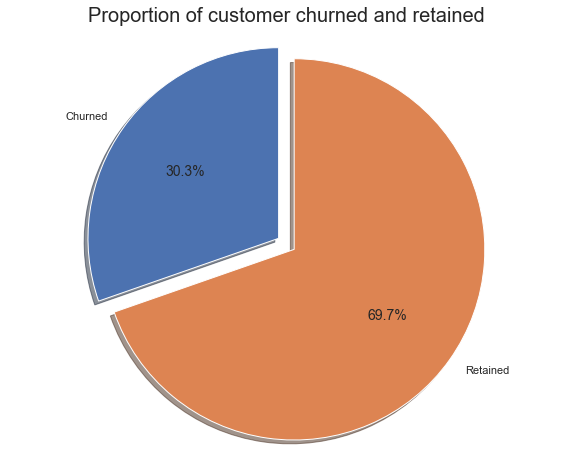

In [245]:
#visualize Churn
labels = 'Churned', 'Retained'
sizes = [final_data.Churn[final_data['Churn']==1].count(), final_data.Churn[final_data['Churn']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

## Churn 

So about 30.3% of the customers have churned. So the baseline model could be to predict that 30.3% of the customers will churn. Given 30.3% is a small number, we need to ensure that the chosen model does predict with great accuracy this 30.3% as it is of interest to the AHG to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

# Data Visualization

Text(0.5, 0, 'Yearly Income')

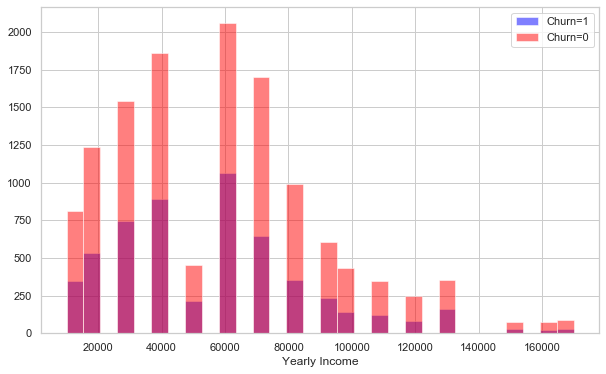

In [246]:
#Churn by customer yearly income
plt.figure(figsize=(10,6))
final_data[final_data['Churn']==1]['YearlyIncome'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
final_data[final_data['Churn']==0]['YearlyIncome'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Yearly Income')

Customer yearly income is one of the determinant of churnners the propensity to churn is more with customers with 60,000 yearly income.

Text(0.5, 0, 'OrderQuantity_sum')

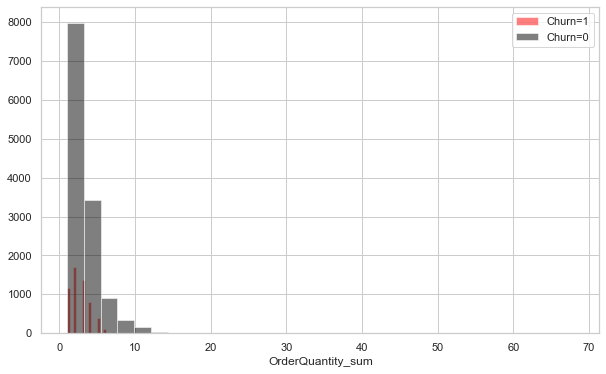

In [247]:
#Churn by customer yearly income
plt.figure(figsize=(10,6))
final_data[final_data['Churn']==1]['OrderQuantity_sum'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=1')
final_data[final_data['Churn']==0]['OrderQuantity_sum'].hist(alpha=0.5,color='black',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('OrderQuantity_sum')

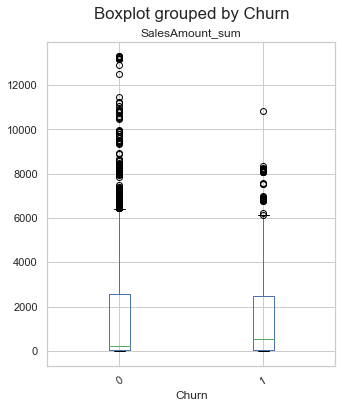

In [248]:
final_data.boxplot('SalesAmount_sum','Churn',rot = 30,figsize=(5,6))

In [249]:
#reviewing the no of records in the target field - Churn
final_data['Churn'].value_counts()

0    12876
1     5608
Name: Churn, dtype: int64

## Unsupervised Technique

As part of feature engineering, we will use RFM analysis to create recency, frequency and monetary(lifetime value) attributes for each customer. Using the derived RFM variables or RFM Score and create a clustering model  using K means algorithms to generate customer segments. Finally use elbow method to select the best number of clusters

In [250]:
#extract year, month and day
Timebtworders = Timebtworders[['SalesOrderNumber','CustomerKey','OrderDate','SalesAmount','OrderQuantity','UnitPrice']]

In [251]:
#extract year, month and day
Timebtworders['OrderDay'] = Timebtworders.OrderDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
Timebtworders.head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,UnitPrice,OrderDay
0,SO43697,21768,2010-12-29,3578.2700,1,3578.2700,2010-12-29
1,SO43698,28389,2010-12-29,3399.9900,1,3399.9900,2010-12-29
2,SO43699,25863,2010-12-29,3399.9900,1,3399.9900,2010-12-29
3,SO43700,14501,2010-12-29,699.0982,1,699.0982,2010-12-29
4,SO43701,11003,2010-12-29,3399.9900,1,3399.9900,2010-12-29


In [252]:
# print the time period
print('Min : {}, Max : {}'.format(min(Timebtworders.OrderDay), max(Timebtworders.OrderDay)))
print('The last transaction date is January 28th 2014')

Min : 2010-12-29 00:00:00, Max : 2014-01-28 00:00:00
The last transaction date is January 28th 2014


In [253]:
# pin the last date
pin_date = max(Timebtworders.OrderDay) + dt.timedelta(1)

In [254]:
# Create total spend dataframe
Timebtworders['TotalSum'] = Timebtworders.OrderQuantity * Timebtworders.UnitPrice
Timebtworders.head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,UnitPrice,OrderDay,TotalSum
0,SO43697,21768,2010-12-29,3578.2700,1,3578.2700,2010-12-29,3578.2700
1,SO43698,28389,2010-12-29,3399.9900,1,3399.9900,2010-12-29,3399.9900
2,SO43699,25863,2010-12-29,3399.9900,1,3399.9900,2010-12-29,3399.9900
3,SO43700,14501,2010-12-29,699.0982,1,699.0982,2010-12-29,699.0982
4,SO43701,11003,2010-12-29,3399.9900,1,3399.9900,2010-12-29,3399.9900


## Calculating RFM values

In [255]:
# calculate RFM values
rfm = Timebtworders.groupby('CustomerKey').agg({
    'OrderDate' : lambda x: (pin_date - x.max()).days,
    'OrderQuantity' : 'count', 
    'TotalSum' : 'sum'})
# rename the columns
rfm.rename(columns = {'OrderDate' : 'Recency', 
                      'OrderQuantity' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,271,8,8248.99
11001,50,11,6383.88
11002,340,4,8114.04
11003,264,9,8139.29
11004,273,6,8196.01


As the three columns are grouped by customers and count the days from the max date value, Recency is the days since the last purchase of a customer. Frequency is the number of purchases of a customer and Monetary is the total amount of spend of a customer.

## RFM quartiles

Let's group the customers based on Recency and Frequency. We will use quantile values to get three equal percentile groups and then make three separate groups. As the lower Recency value is the better, we will label them in decreasing order.

In [256]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

m_groups.head()

CustomerKey
11000    4
11001    4
11002    4
11003    4
11004    4
Name: Monetary, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [257]:
# make a new column for group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [258]:
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerKey,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0
11001,50,11,6383.88,4,4,4,444,12.0
11002,340,4,8114.04,1,3,4,134,8.0
11003,264,9,8139.29,2,4,4,244,10.0
11004,273,6,8196.01,1,4,4,144,9.0


With this value, we can go further analysis such as what is the average values for each RFM values or leveling customers in total RFM score.

In [259]:
# calculate average values for each RFM
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         315.3       1.6     22.9  1014
4.0         255.9       1.9     39.4  1494
5.0         257.9       2.0    471.7  2500
6.0         236.1       2.2    834.8  3053
7.0         176.6       2.8   1245.9  2512

In [260]:
# assign labels from total score
# The final score will be the aggregated value of RFM and we can make groups based on the RFM_Score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerKey,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver
11001,50,11,6383.88,4,4,4,444,12.0,Gold
11002,340,4,8114.04,1,3,4,134,8.0,Silver
11003,264,9,8139.29,2,4,4,244,10.0,Gold
11004,273,6,8196.01,1,4,4,144,9.0,Silver


## Customer Segmentation with Kmeans

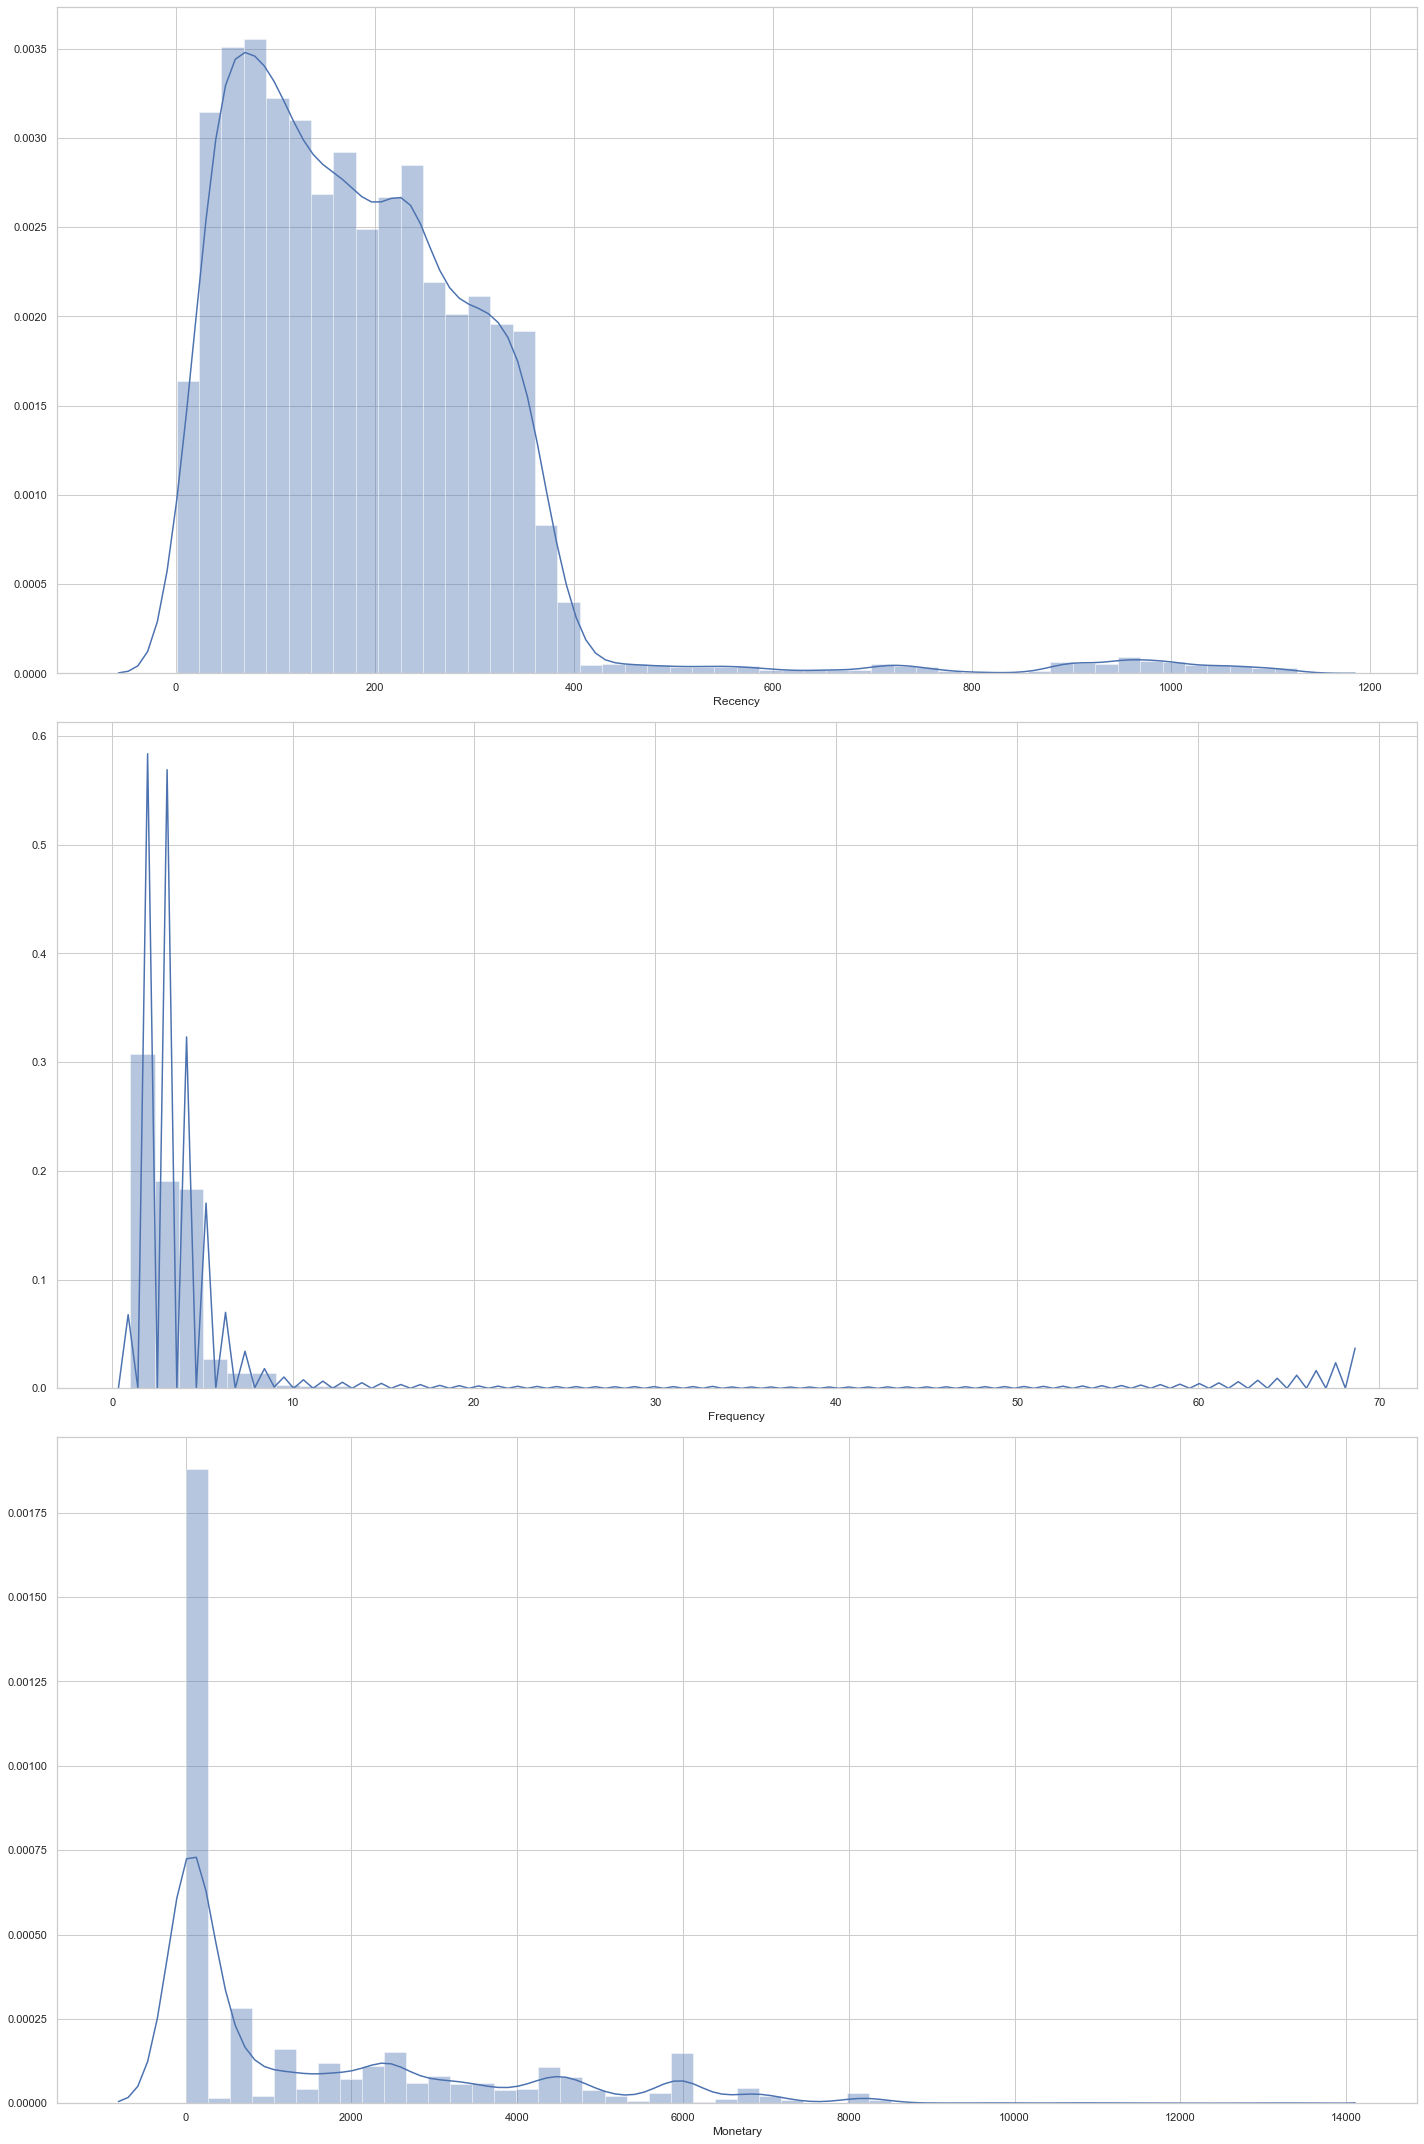

In [261]:
# plot the distribution of RFM values
fig, axarr = plt.subplots(3, 1, figsize=(20, 30))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [262]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [263]:
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerKey,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver
11001,50,11,6383.88,4,4,4,444,12.0,Gold
11002,340,4,8114.04,1,3,4,134,8.0,Silver
11003,264,9,8139.29,2,4,4,244,10.0,Gold
11004,273,6,8196.01,1,4,4,144,9.0,Silver


In [264]:
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,5.602,2.079,9.018
11001,3.912,2.398,8.762
11002,5.829,1.386,9.001
11003,5.576,2.197,9.004
11004,5.609,1.792,9.011


In [265]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,18484.000000,18484.000000,18484.000000
mean,4.939616,1.009275,5.771886
std,0.902116,0.566096,2.182740
min,0.000000,0.000000,0.829000
25%,4.466000,0.693000,3.911000
50%,5.130000,1.099000,5.599500
75%,5.576000,1.386000,7.829000
max,7.027000,4.220000,9.495000


In [266]:
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [267]:
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,0.734276,1.889704,1.487214
11001,-1.139147,2.453227,1.369927
11002,0.985913,0.665497,1.479426
11003,0.705454,2.098154,1.480800
11004,0.742035,1.382709,1.484007


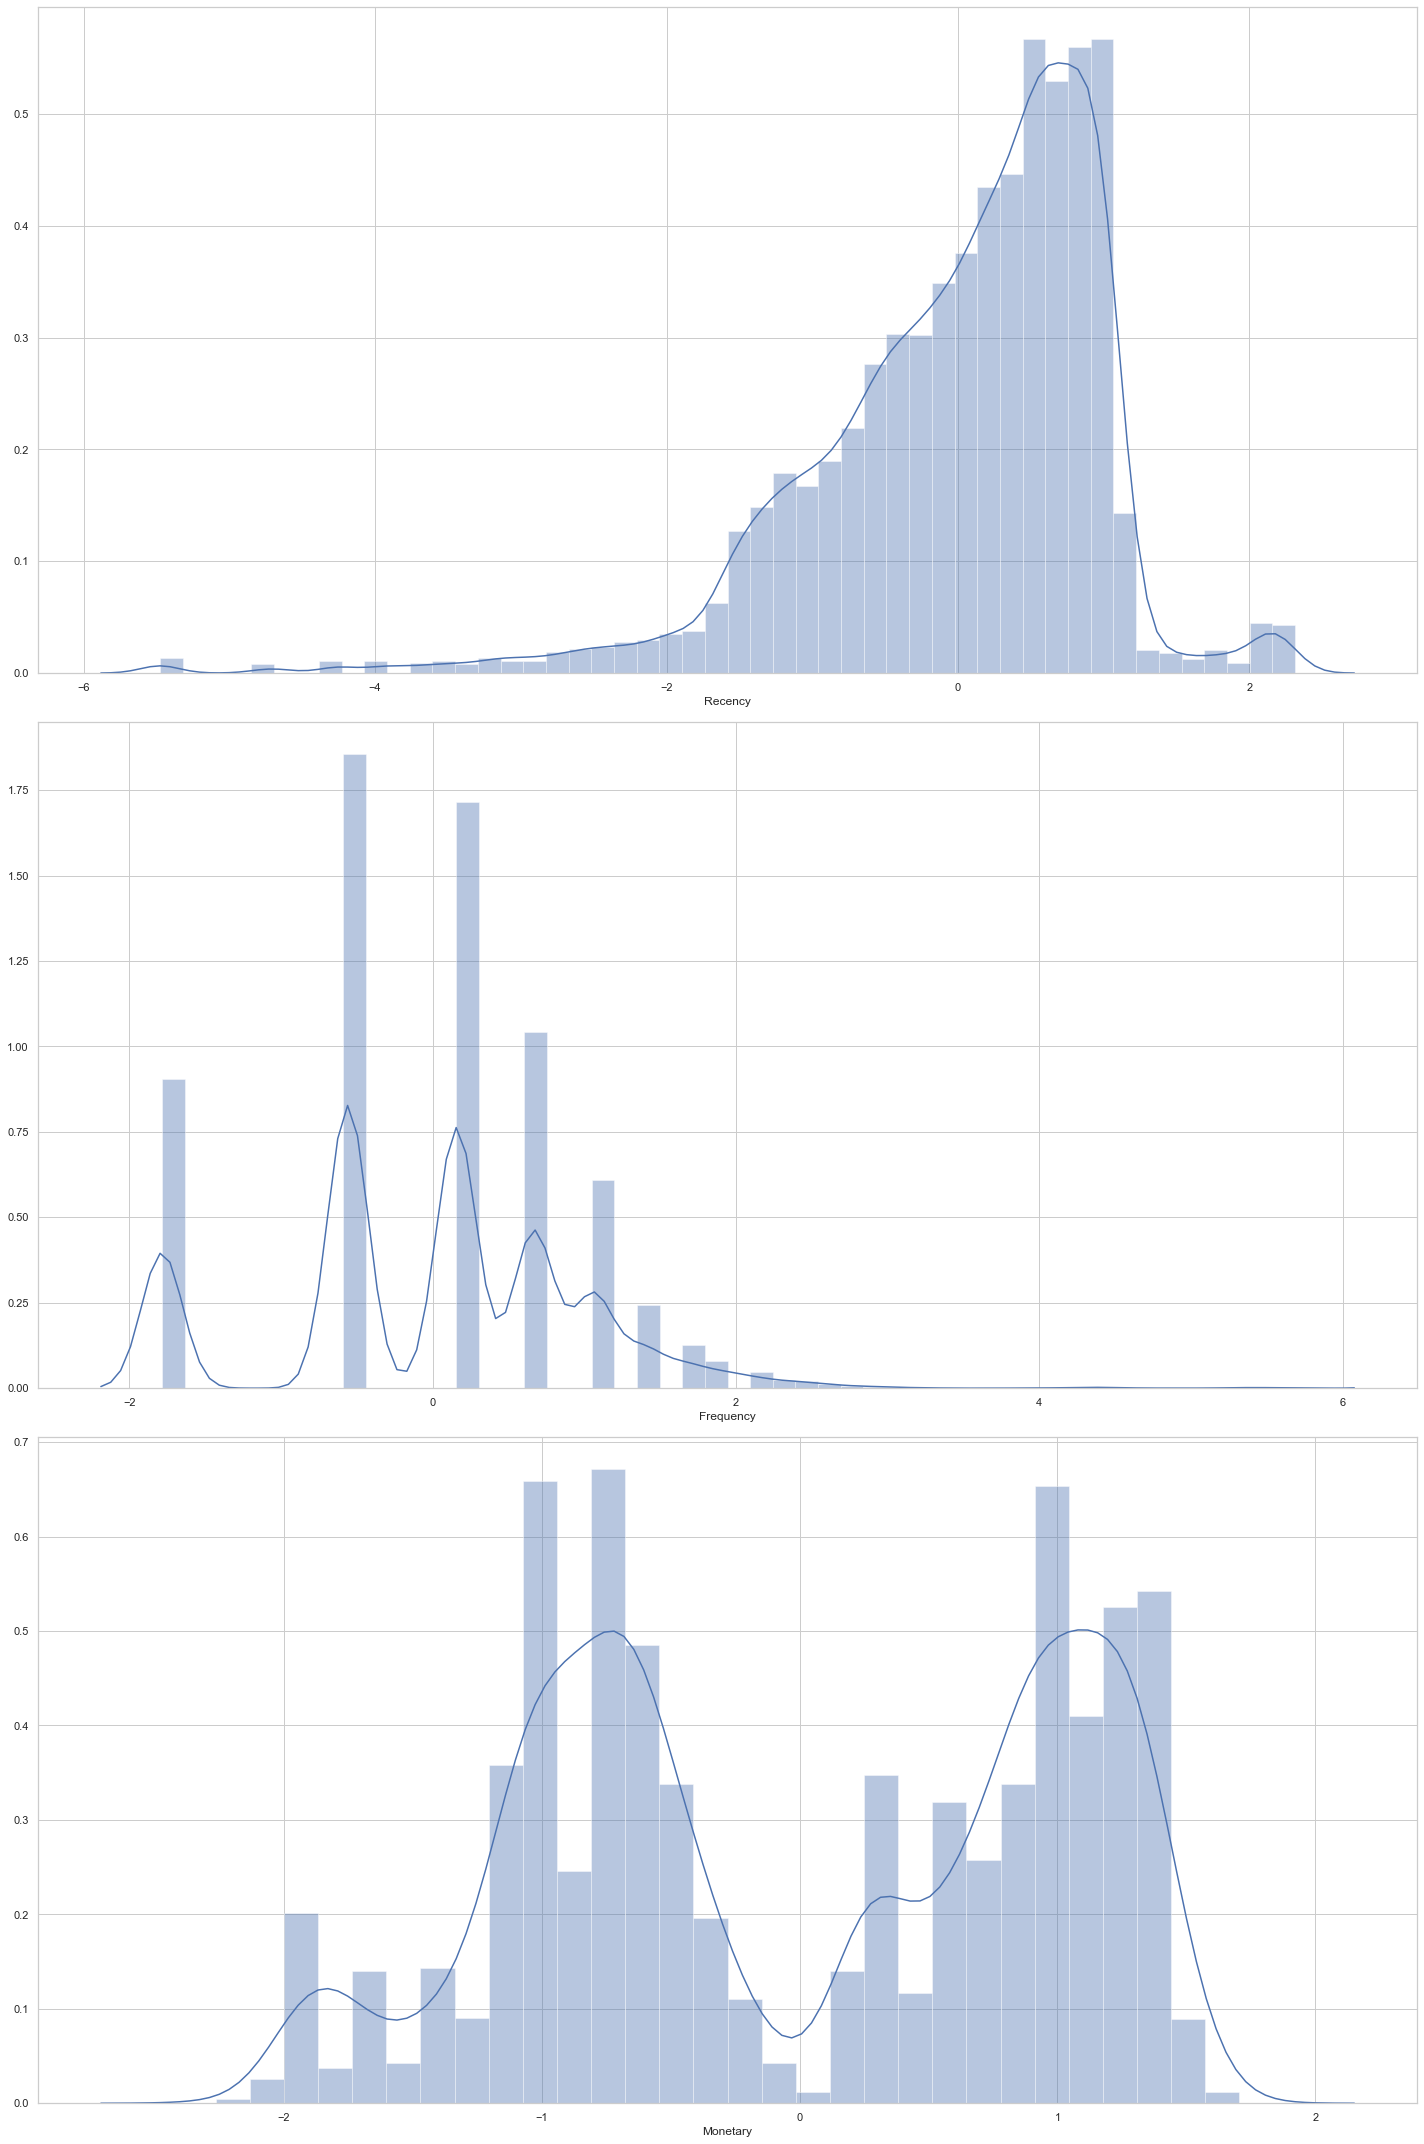

In [268]:
# plot the distribution of RFM values
fig, axarr = plt.subplots(3, 1, figsize=(20, 30))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

## K-means clustering

With the Elbow method, we can get the optimal number of clusters.

In [269]:
# the Elbow method
from sklearn.cluster import KMeans
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_

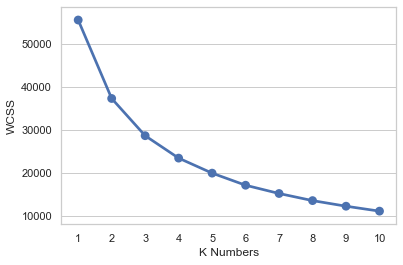

In [270]:
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [271]:
# clustering
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300,)# Lets select 3 clusters 
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [272]:
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerKey,,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver,1
11001,50,11,6383.88,4,4,4,444,12.0,Gold,1
11002,340,4,8114.04,1,3,4,134,8.0,Silver,1
11003,264,9,8139.29,2,4,4,244,10.0,Gold,1
11004,273,6,8196.01,1,4,4,144,9.0,Silver,1


In [273]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)

In [274]:
rfm_scaled.head()

,CustomerKey,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,11000,0.734276,1.889704,1.487214,1,Silver
1,11001,-1.139147,2.453227,1.369927,1,Gold
2,11002,0.985913,0.665497,1.479426,1,Silver
3,11003,0.705454,2.098154,1.480800,1,Gold
4,11004,0.742035,1.382709,1.484007,1,Silver


In [275]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerKey', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head(10)

,CustomerKey,RFM_Level,K_Cluster,Metrics,Value
0,11000,Silver,1,Recency,0.734276
1,11001,Gold,1,Recency,-1.139147
2,11002,Silver,1,Recency,0.985913
3,11003,Gold,1,Recency,0.705454
4,11004,Silver,1,Recency,0.742035
5,11005,Silver,1,Recency,0.738710
6,11006,Gold,1,Recency,0.688826
7,11007,Silver,1,Recency,0.904990
8,11008,Silver,1,Recency,0.962634
9,11009,Silver,1,Recency,0.709888


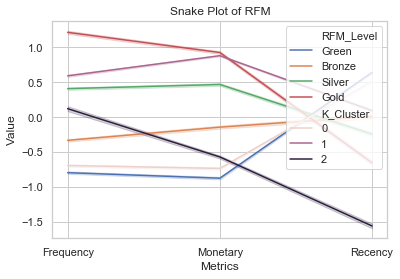

In [276]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

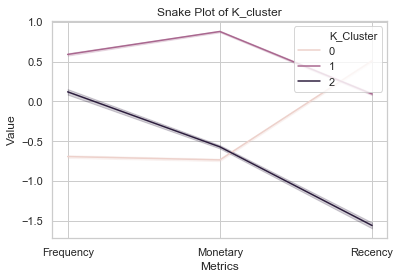

In [277]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

In [278]:
# the mean value for each cluster
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
cluster_avg.head()

,Recency,Frequency,Monetary
RFM_Level,,,
Green,268.918331,1.880192,251.884870
Bronze,209.248877,2.476550,1020.398001
Silver,146.340107,3.685775,2058.933112
Gold,99.737948,6.044808,3953.402540


In [279]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

Recency       190.332450
Frequency       3.245510
Monetary     1588.329216
dtype: float64

In [280]:
# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recency,Frequency,Monetary
RFM_Level,,,
Green,0.412887,-0.420679,-0.841415
Bronze,0.099386,-0.236930,-0.357565
Silver,-0.231134,0.135654,0.296289
Gold,-0.475980,0.862514,1.489032


[]

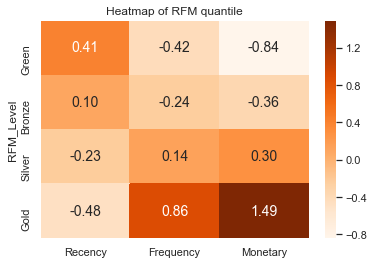

In [281]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

In [282]:
# the mean value for each cluster
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]
cluster_avg_K.head()

,Recency,Frequency,Monetary
K_Cluster,,,
0,259.480979,2.044226,324.717351
1,179.430720,4.221893,3220.511777
2,45.101943,3.591885,279.002152


In [283]:
# the proportional mean value
prop_rfm_K = cluster_avg_K/total_avg - 1
prop_rfm_K

,Recency,Frequency,Monetary
K_Cluster,,,
0,0.363304,-0.370137,-0.795560
1,-0.057277,0.300841,1.027610
2,-0.763036,0.106725,-0.824342


[]

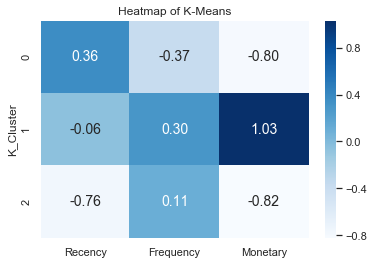

In [284]:
# heatmap
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()

## Supervised Technique

We will split the Non Churn dataset into two, train and Hold out sample, thereafter concatenate the Non Churnners and  Churners dataset to model. The holdout sample data will be used for scoring and deployment

In [285]:
#Keep an hold out sample for scoring and deployment. 
#extract only churners
Churners = final_data.loc[final_data['Churn'] == 1] 
#Extract only first 6973 rows from Non churners
non_churners = final_data.loc[final_data['Churn'] == 0]
Score_data = final_data.loc[final_data['Churn'] == 0].tail(6000)

In [286]:
#Counting Churners
Churners['Churn'].value_counts()


1    5608
Name: Churn, dtype: int64

In [287]:
#Counting non churners
non_churners['Churn'].value_counts()

0    12876
Name: Churn, dtype: int64

### Lets randomly seperate the 12876 Non-Churnners into two groups:
 >50% - Non-Churners are for training, validating, and testing the model.
 
 >50% - Score_data - for scoring the model which is going to be our hold-out sample 

We will use the train_test_split funtions to achieve random selection of the data, this is not for model purpose or data partitioning, its only to split the data and select a hold out sample.

In [288]:
Score_data,Non_churners = train_test_split(non_churners,test_size=0.5,random_state=42)

In [289]:
Non_churners['Churn'].value_counts()

0    6438
Name: Churn, dtype: int64

In [290]:
# This is my hold out sample for scoring/deployment
Score_data['Churn'].value_counts()

0    6438
Name: Churn, dtype: int64

In [291]:
Score_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
5891,16891,59.98,54.99,4.99,29.990000,29.99,2,1,1,1.0,...,0,1,0,0,1,0,0,0,0,1
1802,12802,39.98,34.99,4.99,19.990000,19.99,2,1,1,1.0,...,0,0,0,0,1,0,1,0,0,0
16969,27969,599.47,539.99,24.49,199.823333,34.99,3,1,1,1.0,...,0,1,0,0,1,0,0,1,0,0
1864,12864,86.24,34.99,2.29,14.373333,7.49,6,1,1,1.0,...,0,0,0,0,1,1,0,0,0,0
12820,23820,37.27,29.99,2.29,12.423333,4.99,3,1,1,1.0,...,0,0,1,0,1,0,1,0,0,0


In [292]:
#Append Churners and non churners excluding the hold out sample for scoring
model_data = pd.concat([Churners, Non_churners],ignore_index=True)

In [293]:
model_data['Churn'].value_counts()

0    6438
1    5608
Name: Churn, dtype: int64

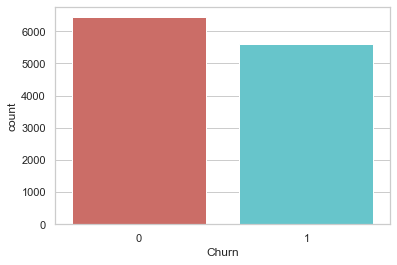

<Figure size 432x288 with 0 Axes>

In [294]:
#Display the distribution of the target variable - 0 = Non Churner - 1 = Churner
sns.countplot(x='Churn', data = model_data, palette = 'hls')
plt.show()
plt.savefig('count_plot')

### Measures of central tendencies - investigating the difference between the averages of independent variables vs the target variables

In [295]:
model_data.groupby('Churn').mean()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
Churn,,,,,,,,,,,,,,,,,,,,,
0,19776.865176,1627.563304,1013.607887,85.022856,453.729407,332.232457,3.531532,1.022367,1.0,1.005254,...,0.127679,0.300249,0.244175,0.318111,0.681889,0.333955,0.176452,0.136222,0.175054,0.178316
1,21223.324358,1507.150998,1126.615587,329.717209,648.768105,542.614357,2.694365,1.019080,1.0,1.004877,...,0.130350,0.283702,0.272290,0.333631,0.666369,0.337553,0.186163,0.125178,0.186876,0.164230


Text(0, 0.5, 'Frequency')

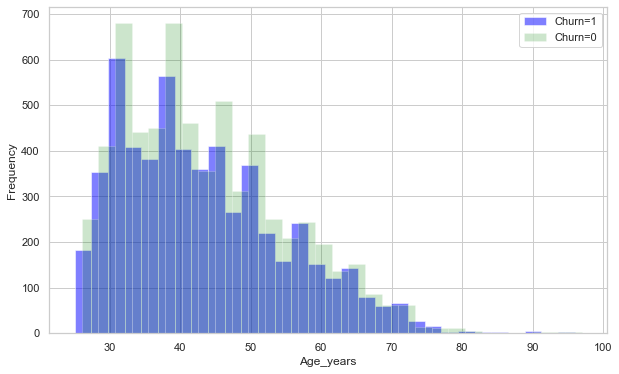

In [296]:
#Most of the customers in this dataset are in the age range of 30–50.
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Age_years'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Age_years'].hist(alpha=0.2,color='green',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Age_years')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

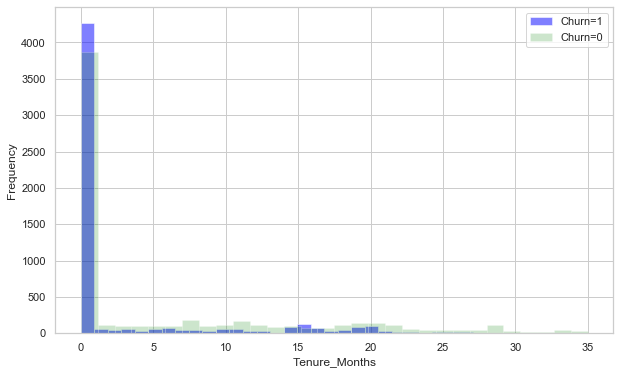

In [297]:
#Investigating Churn versus Tenure Months.
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Tenure_Months'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Tenure_Months'].hist(alpha=0.2,color='green',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Tenure_Months')
plt.ylabel('Frequency')

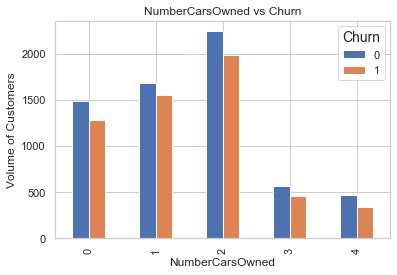

In [298]:
#No of children does not seem to be a good predictor of the outcome variable.
pd.crosstab(model_data.NumberCarsOwned,model_data.Churn).plot(kind='bar')
plt.title('NumberCarsOwned vs Churn')
plt.xlabel('NumberCarsOwned')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

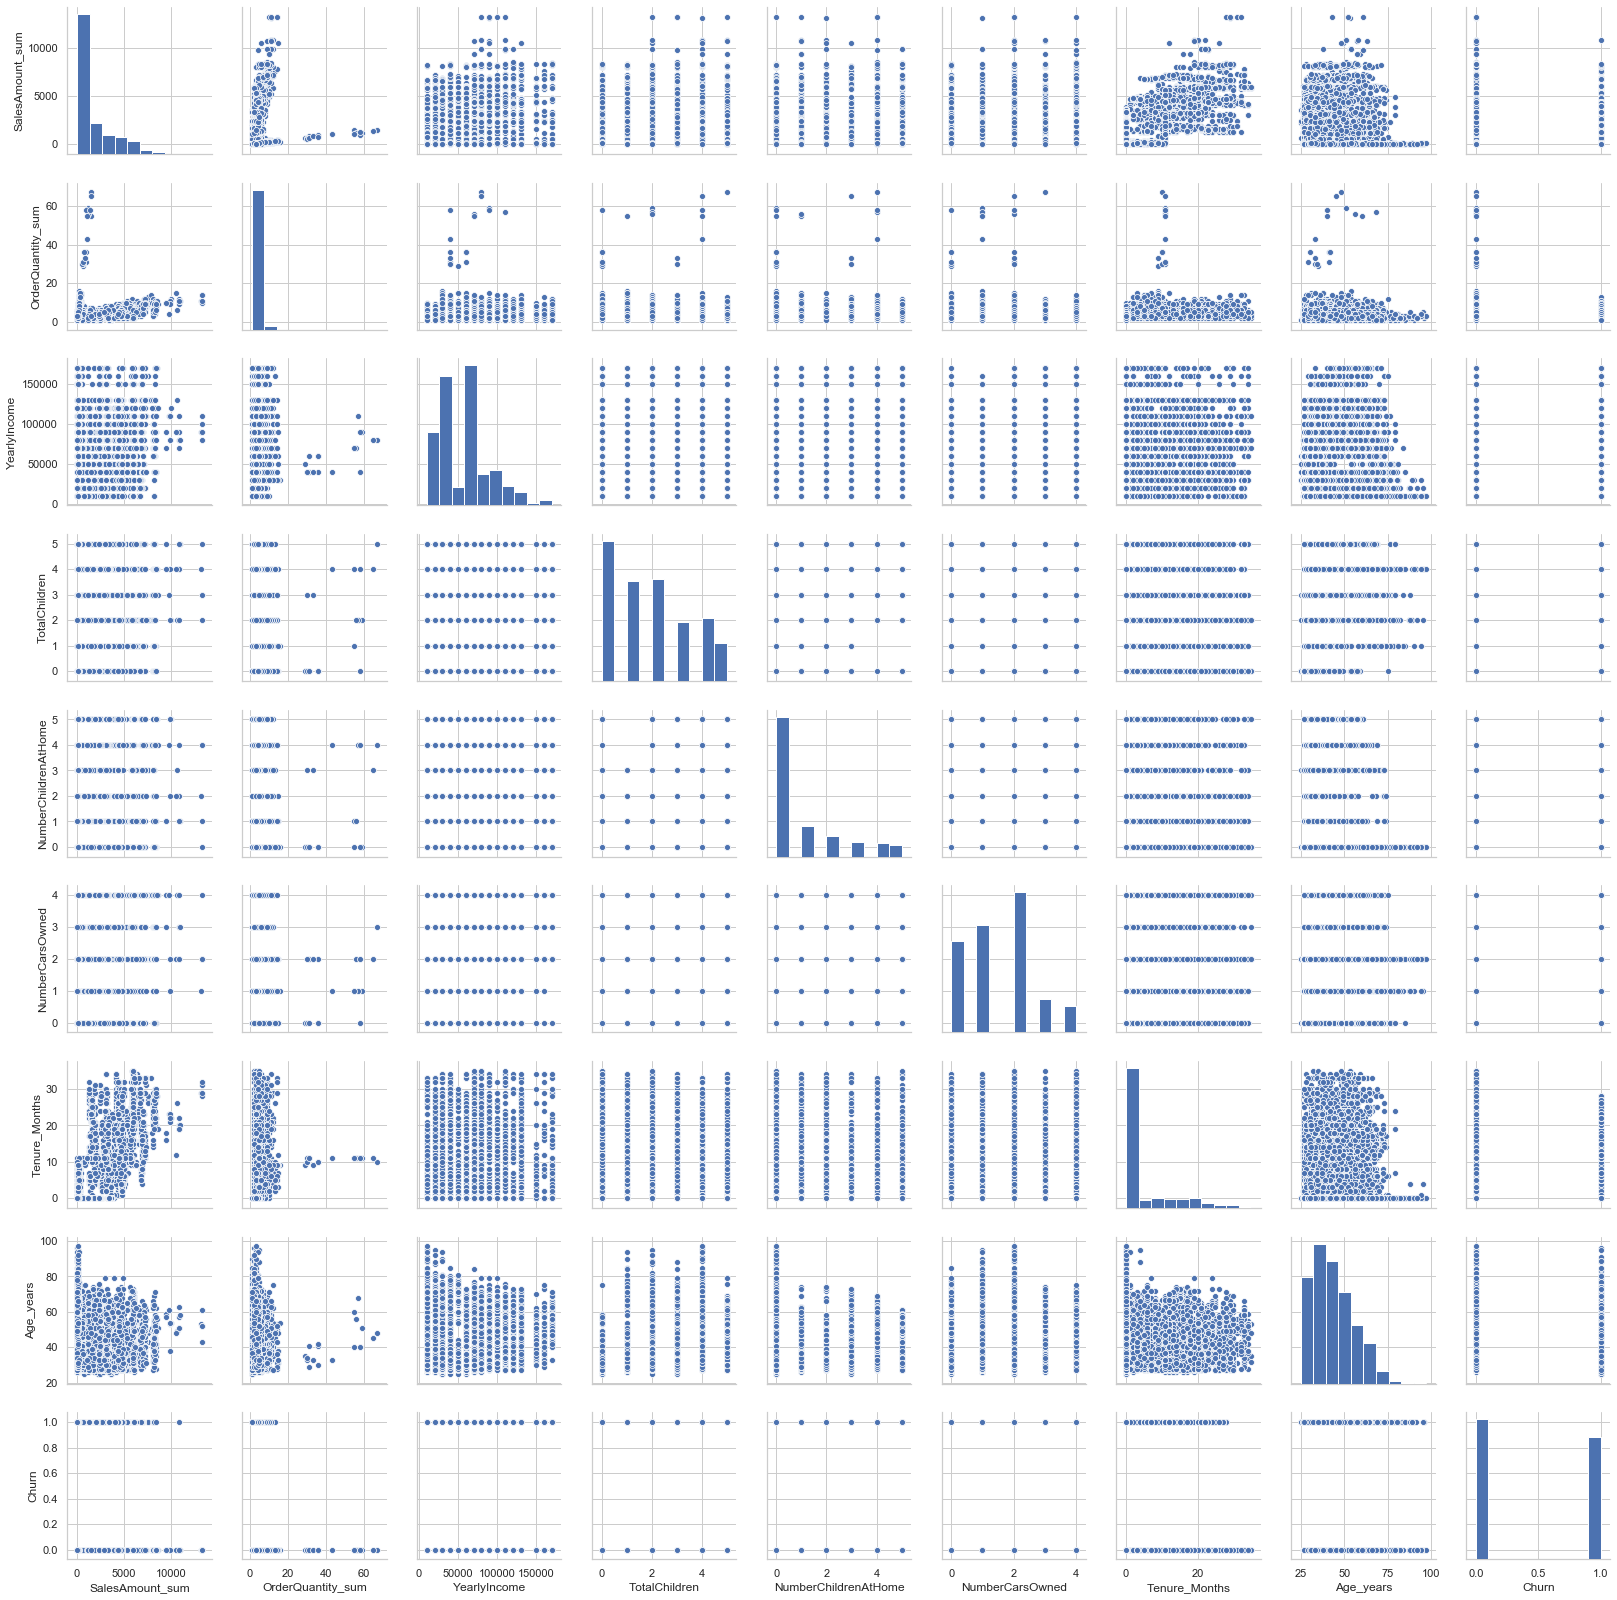

In [299]:
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#newdf = model_data.select_dtypes(include=numerics)
x = model_data[['SalesAmount_sum', 'OrderQuantity_sum', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned', 'Tenure_Months', 'Age_years', 'Churn']]
sns.pairplot(x)


In [300]:
#check the correlation of the input features with one another.
print(model_data.corr())


                                      CustomerKey  SalesAmount_sum  \
CustomerKey                              1.000000        -0.234345   
SalesAmount_sum                         -0.234345         1.000000   
SalesAmount_max                         -0.095450         0.923041   
SalesAmount_min                          0.227390         0.224853   
SalesAmount_mean                         0.060364         0.724560   
SalesAmount_median                       0.108798         0.537391   
OrderQuantity_sum                       -0.320542         0.277559   
OrderQuantity_max                       -0.004255         0.029235   
OrderQuantity_min                             NaN              NaN   
OrderQuantity_mean                       0.026747         0.006321   
OrderQuantity_median                     0.009695        -0.014293   
diff_sum                                -0.302973         0.784438   
diff_max                                -0.276675         0.763416   
diff_min            

In [301]:
#Identify missing values
model_data.isnull().mean().sort_values(ascending=False)*100

Quality                                 8.293209
Price                                   8.293209
Review                                  8.293209
Television  Advertisement               8.293209
On Promotion                            8.293209
Manufacturer                            8.293209
Other                                   8.293209
OrderQuantity_sum                       0.000000
OrderQuantity_max                       0.000000
SalesAmount_sum                         0.000000
SalesAmount_max                         0.000000
SalesAmount_min                         0.000000
SalesAmount_mean                        0.000000
DateFirstPurchase                       0.000000
NumberCarsOwned                         0.000000
NumberChildrenAtHome                    0.000000
TotalChildren                           0.000000
YearlyIncome                            0.000000
BirthDate                               0.000000
diff_median                             0.000000
diff_mean           

In [302]:
#replace missing values with most frequent values
model_data = model_data.fillna(model_data.mode().iloc[0])

In [303]:
#Carry out a statistical test to understand key statistical elements
model_data.describe()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
count,12046.000000,12046.000000,12046.000000,12046.000000,12046.000000,12046.000000,12046.000000,12046.000000,12046.0,12046.000000,...,12046.000000,12046.000000,12046.000000,12046.000000,12046.000000,12046.00000,12046.000000,12046.000000,12046.000000,12046.000000
mean,20450.262411,1571.505508,1066.218478,198.940001,544.529425,430.175483,3.141790,1.020837,1.0,1.005079,...,0.128922,0.292545,0.257264,0.325336,0.674664,0.33563,0.180973,0.131081,0.180558,0.171758
std,5361.787856,2069.086647,1257.955520,660.789508,767.911567,795.203717,2.492859,0.142844,0.0,0.037309,...,0.335128,0.454950,0.437144,0.468520,0.468520,0.47223,0.385012,0.337503,0.384667,0.377186
min,11000.000000,2.290000,2.290000,2.290000,2.290000,2.290000,1.000000,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,15880.250000,49.970000,34.990000,4.990000,20.156667,17.490000,2.000000,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,20519.500000,539.990000,539.990000,4.990000,112.942000,32.490000,3.000000,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,25076.500000,2500.217500,2294.990000,28.990000,863.350576,539.990000,4.000000,1.000000,1.0,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
max,29483.000000,13294.270000,3578.270000,3578.270000,3578.270000,3578.270000,67.000000,2.000000,1.0,1.666667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


## 4.0 Variable Selection - Vote based approach

We are going to use 6 means to select the best variable since we are not going to work with all the variables in our dataset. In selecting the variables we are going to using a vote based approach in which all the variables will be scored and the best score will be used.

In [304]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = model_data.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    model_data[i] = d[i].transform(model_data[i].fillna('NA'))

In [305]:
model_data.head(5) #Display the new table

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,4.99,1031.123750,44.490,8,1,1,1.0,...,0,1,0,0,1,0,1,0,0,0
1,11002,8114.04,3399.99,34.99,2028.510000,2339.530,4,1,1,1.0,...,0,1,0,0,1,0,0,0,1,0
2,11003,8139.29,3399.99,2.29,904.365556,9.990,9,1,1,1.0,...,0,1,0,1,0,0,0,0,0,1
3,11004,8196.01,3399.99,21.98,1366.001667,1177.490,6,1,1,1.0,...,0,1,0,0,1,0,1,0,0,0
4,11005,8121.33,3374.99,2.29,1353.555000,1177.495,6,1,1,1.0,...,0,1,0,0,1,0,0,0,0,1


In [306]:
#Select features and target thereby building our feature table
features = model_data[model_data.columns.difference(['Churn','CustomerKey','OrderDate_max','SalesAmount_max', 'SalesAmount_min','SalesAmount_mean', 'SalesAmount_median','OrderQuantity_min','OrderQuantity_max', 'OrderQuantity_mean', 'OrderQuantity_median','Cuttoff_date','Last_purchase_date','DateFirstPurchase','BirthDate'])]
labels = model_data['Churn']

In [307]:
features.head()

,Age_years,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,...,SalesAmount_sum,Television Advertisement,Tenure_Months,TotalChildren,YearlyIncome,diff_max,diff_mean,diff_median,diff_min,diff_sum
0,41,0,1,0,0,0,1,0,0,0,...,8248.99,0.0,27,2,90000.0,730,104.375000,0.0,0,835
1,42,0,0,0,1,0,1,0,0,0,...,8114.04,0.0,25,3,60000.0,724,194.500000,27.0,0,778
2,39,0,0,0,0,1,1,0,0,0,...,8139.29,0.0,28,0,70000.0,738,95.888889,0.0,0,863
3,33,0,1,0,0,0,1,0,0,0,...,8196.01,0.0,27,5,80000.0,730,138.166667,0.0,0,829
4,36,0,0,0,0,1,1,0,0,0,...,8121.33,0.0,28,0,70000.0,755,142.333333,0.0,0,854


In [308]:
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn, dtype: int32

# 4.1 Weight of Evidence (WOE) and Information Value (IV)

In [309]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [310]:
#Let get the independent variables 
final_iv, IV = data_vars(model_data[model_data.columns.difference(['Churn','CustomerKey','OrderDate_max','SalesAmount_max', 'SalesAmount_min','SalesAmount_mean', 'SalesAmount_median','OrderQuantity_min','OrderQuantity_max', 'OrderQuantity_mean', 'OrderQuantity_median','Cuttoff_date','Last_purchase_date','DateFirstPurchase','BirthDate'])],model_data.Churn)


### We want to know the relationship between an independent variables and a dependent variable (“Churn”).

In [311]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
26,OrderQuantity_sum,0.139851
37,diff_mean,0.139779
33,Tenure_Months,0.139158
40,diff_sum,0.138883
36,diff_max,0.138883
29,Quality,0.047256
20,Manufacturer,0.040832
28,Price,0.032775
32,Television Advertisement,0.013410
35,YearlyIncome,0.008286


# 4.2 Variable Importance using Random Forest

In [312]:
#Display our label table 
labels.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Churn, dtype: int32

In [313]:
#import library
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels) #Fit features and labels

preds = clf.predict(features) #Predict the classification score of features

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)#Get the classification accuracy level/score
print(accuracy)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9809065249875477


>From the above code With 99% accuracy, the classfication score is very accurate.

In [314]:
#import library
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns) # RF stands for Random Forest

In [315]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
31,SalesAmount_sum,0.203379
0,Age_years,0.128139
26,OrderQuantity_sum,0.059767
35,YearlyIncome,0.058283
40,diff_sum,0.047770
36,diff_max,0.044675
34,TotalChildren,0.036564
37,diff_mean,0.034752
23,NumberCarsOwned,0.031151
33,Tenure_Months,0.030817


# 4.3 Recursive Feature Elimination

In [316]:
# Get features that are very important 
#import library
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [317]:
#Import Library
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)# RFE stands for Recursive Feature Elimination
Selected = Selected.reset_index()

In [318]:
Selected[Selected['RFE'] == True] #Display list of very important features 

,index,RFE
1,CommuteDistance_0-1 Miles,True
2,CommuteDistance_1-2 Miles,True
6,EnglishEducation_Bachelors,True
10,EnglishEducation_Partial High School,True
15,EnglishOccupation_Skilled Manual,True
16,Gender_F,True
17,Gender_M,True
18,HouseOwnerFlag_0,True
19,HouseOwnerFlag_1,True
20,Manufacturer,True


# 4.4 Variable Importance using Extratrees Classifier

Extratrees classifier perform similarly to RandomForest, the only major difference is the level of variance, ofcourse extratrees show the lowest variance.

Let us start by importing the library

In [319]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.12779087 0.01326244 0.01140551 0.00736785 0.01132888 0.00912817
 0.01181467 0.00771656 0.0092931  0.0105711  0.00534042 0.00856699
 0.00939418 0.00616609 0.01100901 0.01075271 0.01899475 0.01921497
 0.01299371 0.01262148 0.00668958 0.01616061 0.01684735 0.0361436
 0.0280074  0.01459645 0.08263952 0.01193801 0.00996482 0.02074587
 0.00598333 0.17150273 0.00422732 0.04523792 0.04131245 0.05859598
 0.03028312 0.02176144 0.0037385  0.         0.03889058]


In [320]:
from pandas import DataFrame #import pandas from DATAfRAME 
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [321]:
FI = FI.reset_index()

In [322]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
31,SalesAmount_sum,0.171503
0,Age_years,0.127791
26,OrderQuantity_sum,0.082640
35,YearlyIncome,0.058596
33,Tenure_Months,0.045238
34,TotalChildren,0.041312
40,diff_sum,0.038891
23,NumberCarsOwned,0.036144
36,diff_max,0.030283
24,NumberChildrenAtHome,0.028007


# 4.5 Chi Square

We will use chi square to determine which of the features are very relevant to the outcome that will be predicted and remove those that are unimportant for this model

In [323]:
#Import libraries 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5) #Let select the best the features and expected frequancy of 5
fit = model.fit(features.abs(), labels) 

In [324]:
#Let create a contegancy table from the dataframe table, but first lets import the library from pandas
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [325]:
chi_sq = chi_sq.reset_index()

In [326]:
#display the created table 
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
35,YearlyIncome,323561.78
40,diff_sum,172649.35
36,diff_max,141760.48
37,diff_mean,31103.28
31,SalesAmount_sum,27652.98
33,Tenure_Months,5538.45
38,diff_median,2078.27
26,OrderQuantity_sum,668.59
29,Quality,126.35
20,Manufacturer,108.75


# 4.6 L1 feature selection

We are going to use regularisation to add penalty in every parameters in the machine learning model, the reason for this is to eliminate overfitting in the model.

In [327]:
#Import the libraries
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels) #let set the panelty 
model = SelectFromModel(lsvc,prefit=True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [328]:
#Let test the effectness of various features
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [329]:
#display the performance of all the feature
l1[l1['L1'] == True]

,index,L1
0,Age_years,True
1,CommuteDistance_0-1 Miles,True
6,EnglishEducation_Bachelors,True
15,EnglishOccupation_Skilled Manual,True
22,MaritalStatus_S,True
23,NumberCarsOwned,True
24,NumberChildrenAtHome,True
26,OrderQuantity_sum,True
29,Quality,True
31,SalesAmount_sum,True


### From the above code we could get only 5 features that are selected

# 5 Combine all together

let combine all the six models  we have built above, the reason is for effective scoring and easy comparism amonge them using all the features.

In [330]:
from functools import reduce # import library
dfs = [IV, VI, Selected, FI, chi_sq, l1] #Create a new table for the models built
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs) #Let get our final table 

# Vote each variable

From the code below we will score all the variables using all the models we have built above. But before we can do that, we need to create columns for all the models and bring them into score_table. Meanwhile, it is very important for us to convert some of the models like RFE and L1 that came out as string to integer for easy scoring.

In [331]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square'] #let create a column for all the models built above that are integer 

score_table = pd.DataFrame({},[]) #Create the scoring table fom pandas 
score_table['index'] = final_results['index'] # create Index column that has all the variables

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int) # converting and creating a column for RFE from string to integer
score_table['L1'] = final_results['L1'].astype(int) # Converting and creating a column for L1 from string to integer

In [332]:
score_table['final_score'] = score_table.sum(axis=1)#Sum the scoring from each row into final score column

In [333]:
score_table.sort_values('final_score',ascending=0)# Display the table and sort it by final_score in ascending order

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
26,OrderQuantity_sum,1,1,1,0,1,1,5
40,diff_sum,1,1,0,1,0,1,4
33,Tenure_Months,1,0,1,0,1,1,4
31,SalesAmount_sum,0,1,1,1,0,1,4
36,diff_max,1,0,0,1,0,1,3
35,YearlyIncome,0,1,1,1,0,0,3
0,Age_years,0,1,1,0,0,1,3
22,MaritalStatus_S,0,0,0,0,1,1,2
37,diff_mean,1,0,0,1,0,0,2
32,Television Advertisement,0,0,0,0,1,1,2


From the above we have suceesfully scored and rank all the variables based on the final_score. OrderQuantity_sum has the highest score among all the varaibles, all the models above scored it only Chi_sq that didnt. This is great because our concern is to get the best model with the most important variables for our Label (Churn)

# Multicollinearity

Let us get the level of inter-relationship among all the independent variables, if is high is an issue for our model because the outcome wont be correct. Be as it may, it will increase our confidence in our models and variables.

In [334]:
#import the library
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [335]:
def calculate_vif(features): #Let def the function
    vif = pd.DataFrame() #Build a new a dataframe called varieance inflation factor 
    vif["Features"] = features.columns #Create a column for Features 
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])] #Add column for VIF   
    return(vif) # Return the vif

In [336]:
#Generate a feature table for variables with final score equal or greater than 2
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [337]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any(): #Get VIF greater than 10 
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1] #Remove when the VIF is greater than 10
    features.drop(remove,axis=1,inplace=True) #Drop all variables that fall under the category 
    vif = calculate_vif(features)

In [338]:
#List all the independent variables in VIF.
list(vif['Features'])

['Age_years',
 'CommuteDistance_0-1 Miles',
 'EnglishEducation_Bachelors',
 'EnglishOccupation_Skilled Manual',
 'MaritalStatus_S',
 'OrderQuantity_sum',
 'Quality',
 'SalesAmount_sum',
 'Television  Advertisement',
 'YearlyIncome',
 'diff_mean']

In [339]:
#Describe the new table 
features.describe()

,Age_years,CommuteDistance_0-1 Miles,EnglishEducation_Bachelors,EnglishOccupation_Skilled Manual,MaritalStatus_S,OrderQuantity_sum,Quality,SalesAmount_sum,Television Advertisement,YearlyIncome,diff_mean
count,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00
mean,43.55,0.34,0.29,0.26,0.46,3.14,0.10,1571.51,0.03,56875.31,37.90
std,11.48,0.47,0.45,0.44,0.50,2.49,0.30,2069.09,0.18,32057.42,72.26
min,25.00,0.00,0.00,0.00,0.00,1.00,0.00,2.29,0.00,10000.00,0.00
25%,34.00,0.00,0.00,0.00,0.00,2.00,0.00,49.97,0.00,30000.00,0.00
50%,41.00,0.00,0.00,0.00,0.00,3.00,0.00,539.99,0.00,60000.00,0.00
75%,51.00,1.00,1.00,1.00,1.00,4.00,0.00,2500.22,0.00,70000.00,47.74
max,97.00,1.00,1.00,1.00,1.00,67.00,1.00,13294.27,1.00,170000.00,534.00


In [340]:
#Display the first rows in the new table
features.head(5)

,Age_years,CommuteDistance_0-1 Miles,EnglishEducation_Bachelors,EnglishOccupation_Skilled Manual,MaritalStatus_S,OrderQuantity_sum,Quality,SalesAmount_sum,Television Advertisement,YearlyIncome,diff_mean
0,41,0,1,0,0,8,0.00,8248.99,0.00,90000.00,104.38
1,42,0,1,0,0,4,0.00,8114.04,0.00,60000.00,194.50
2,39,0,1,0,1,9,0.00,8139.29,0.00,70000.00,95.89
3,33,0,1,0,1,6,0.00,8196.01,0.00,80000.00,138.17
4,36,0,1,0,1,6,0.00,8121.33,0.00,70000.00,142.33


From all our coding activities above we have identified and removed all the possible variables that have high inter-relationship which may likly lead to wrong outcome. Now we are left with 12 variables in our feature tables.

# Descriptive Stats and Visualization - For selected variables

We have gotten our truested and reliable independable variables (Features), lets merge this table with our dependable variable Churn. Thereafter we do some cleaning prior visualizing of the table.

In [341]:
#Merge the best list to churn variable
final_vars = list(vif['Features']) + ['Churn']

In [342]:
#fill columns with NAN with and integer 0
df1 = model_data[final_vars].fillna(0)

In [343]:
#Discribe the dataframe to see if any abnormality still exist before visualization
df1.describe()

,Age_years,CommuteDistance_0-1 Miles,EnglishEducation_Bachelors,EnglishOccupation_Skilled Manual,MaritalStatus_S,OrderQuantity_sum,Quality,SalesAmount_sum,Television Advertisement,YearlyIncome,diff_mean,Churn
count,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00,12046.00
mean,43.55,0.34,0.29,0.26,0.46,3.14,0.10,1571.51,0.03,56875.31,37.90,0.47
std,11.48,0.47,0.45,0.44,0.50,2.49,0.30,2069.09,0.18,32057.42,72.26,0.50
min,25.00,0.00,0.00,0.00,0.00,1.00,0.00,2.29,0.00,10000.00,0.00,0.00
25%,34.00,0.00,0.00,0.00,0.00,2.00,0.00,49.97,0.00,30000.00,0.00,0.00
50%,41.00,0.00,0.00,0.00,0.00,3.00,0.00,539.99,0.00,60000.00,0.00,0.00
75%,51.00,1.00,1.00,1.00,1.00,4.00,0.00,2500.22,0.00,70000.00,47.74,1.00
max,97.00,1.00,1.00,1.00,1.00,67.00,1.00,13294.27,1.00,170000.00,534.00,1.00


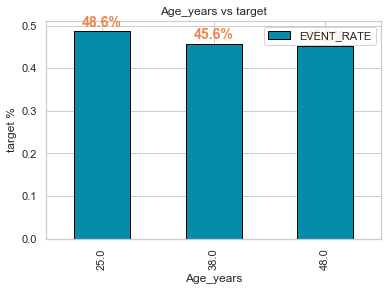

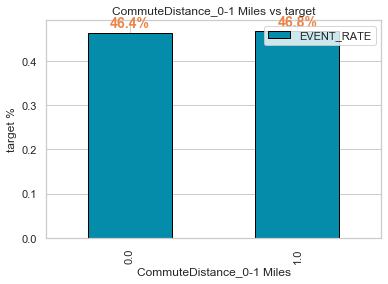

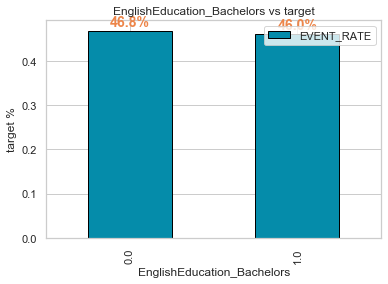

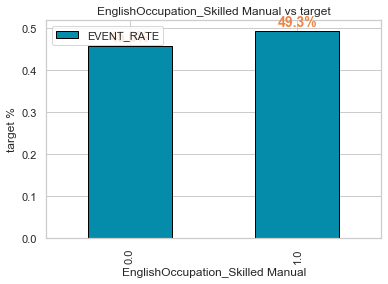

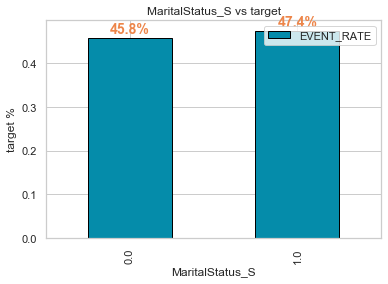

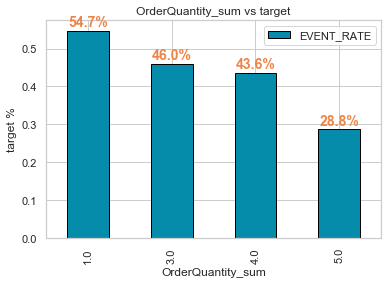

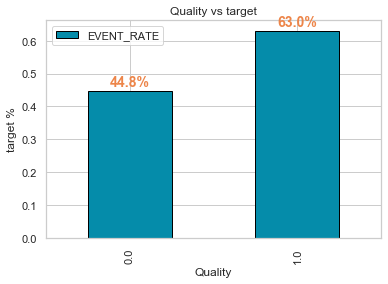

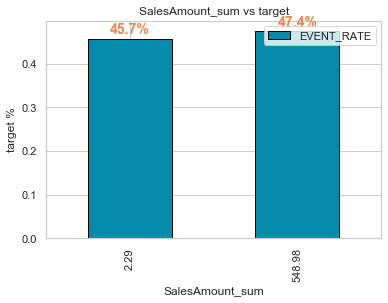

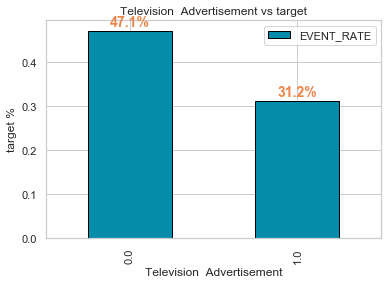

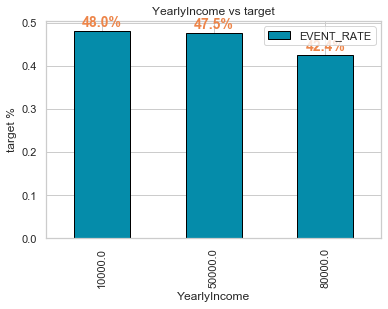

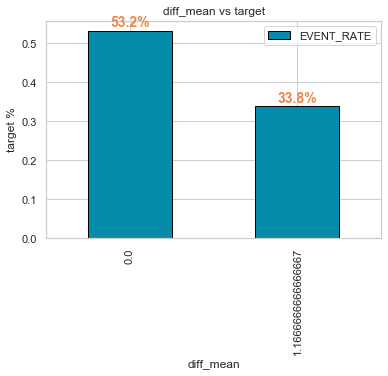

In [344]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['Churn'])
final_iv = final_iv[(final_iv.VAR_NAME != 'Churn')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

## Cross Validation

We have successfully clean and selected our vriables, meaning we have Features, Labels and Hold Out sample data ready. it is time to validate all the various to enable us make the right choice of model using Cross validation

In [345]:
from sklearn.model_selection import train_test_split # Import the library
#Since we are using cross validation here, we will allow almost 100% of the data in train
train, test = train_test_split(df1, test_size=0.001, random_state=0) 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [346]:
#implement cross validation, the cross_val_score method of the sklearn.model_selection library can be used. 
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=0) #The number of trees in the randomforest is 300

In [347]:
from sklearn.model_selection import cross_val_score #import the library 
#Lets get accurancies for 5 folds in the cross validation
all_accuracies = cross_val_score(estimator=classifier, X=features_train, y=label_train, cv=5) 

In [348]:
print(all_accuracies) 

[0.64659468 0.64894059 0.66375727 0.6566916  0.65004156]


In [349]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score
print(all_accuracies.mean()) 

0.6532051429793253


In [350]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.006251330835355026


##  Cross Validation using Logistic Regression 

In [351]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()


In [352]:
all_accuracies = cross_val_score(estimator=clf, X=features_train, y=label_train, cv=5)  

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [353]:
print(all_accuracies) 

[0.56976744 0.57997507 0.57896924 0.58229426 0.56483791]


In [354]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score
print(all_accuracies.mean()) 

0.5751687855397817


In [355]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.006696535327346482


## Grid Search for Parameter Selection
instead of randomly selecting the values of the parameters, a better approach would be to develop an algorithm which automatically finds the best parameters for a particular model. Grid Search is one such algorithm.

In [356]:
#Let create the grid_param dictionary with these parameters n_estimators, criterion and bootstrap
grid_param ={
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [357]:
import sklearn #import sklearn
print(sklearn.__version__) #Get the vision of sklearn

0.21.2


In [358]:
#Import GridSearchCV from SKlearn
from sklearn.model_selection import learning_curve,GridSearchCV
gd_sr = GridSearchCV(estimator=classifier,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10, 
                     n_jobs=-1) #We are going to use all the computing power of the CPU which stands for -1

In [359]:
#Once the GridSearchCV class is initialized, the last step is to call the fit method of the class and pass it the training and 
#test set, as shown in the following code:
gd_sr.fit(features_train, label_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'boots

In [360]:
#the next step is to check the parameters that return the highest accuracy
best_parameters = gd_sr.best_params_  
print(best_parameters)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 150}


The result shows that the highest accuracy is achieved when the n_estimators are 100, bootstrap is True and criterion is "gini".

The last and final step of Grid Search algorithm is to find the accuracy obtained using the best parameters. Previously we had a mean accuracy of 66.72% with 300 n_estimators.

In [361]:
#To find the best accuracy achieved, execute the following code:
best_result = gd_sr.best_score_  
print(best_result)

0.6581068727665587


The accuracy achieved is: 0.6591 of 65.91% which is only slightly below 69.72%.

## Lets check the performance of the models and select the best for the project 

In [362]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [363]:
all_features = pd.concat([features_train, features_test])
all_labels = pd.concat([label_train, label_test])

## RandomForestClassifier

In [364]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)#Fit in RandomForestClassifier into the features and label data
#Predict the performance of the model
pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
#lets plot the AUC and ROC to get the performance of the model
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)#print the out come 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9738480697384807 0.6447395725254202 0.9974216114157209 0.7027626637592372


From the code above we can see that the train accuracy is 99.18%, and AUC is 99.98% which makes it great because the highier the AUC the better for the model

In [365]:
#Train result using RandomForestClassifier
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,3814,49
1,140,3224


In [366]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1890,685
1,1027,1217


## Logistic Regression

In [367]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.5810156358101564 0.5681676696410044 0.6342296484560526 0.6266237474689789


C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [368]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2687,1176
1,1852,1512


In [369]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1778,797
1,1284,960


## Neural Network

In [370]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.48000553480005537 0.4832952894791451 0.5279514667492411 0.534339684682346


C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [371]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,149,3714
1,44,3320


In [372]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,104,2471
1,19,2225


## Naive Bayes

In [373]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.5580462155804622 0.560074704295497 0.5826073178787257 0.5909123790734299


In [374]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1249,2614
1,580,2784


In [375]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,856,1719
1,401,1843


## Gradient Boosting

In [376]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.6670817766708178 0.6335339282008715 0.7636304117572641 0.7207950435249122


In [377]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2629,1234
1,1172,2192


In [378]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1671,904
1,862,1382


## Performance Tuning

Our best model is RandomForestClassifier with an accurancy of 99.18% and AUC 0f 99.98%. Now lets check the performance of the best to model.

In [379]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    6.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.7s finished


{'n_estimators': 118, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [380]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9161477791614778 0.6522100020751194 0.975064277915761 0.7305583822231452


In [381]:
metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])

(array([0.        , 0.        , 0.        , ..., 0.97152472, 0.97204245,
        1.        ]),
 array([0.        , 0.01724138, 0.01872771, ..., 1.        , 1.        ,
        1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99501496e-01, ...,
        3.37485642e-02, 3.35489639e-02, 1.82973806e-03]))

## Final Model and Model Performance

We have gone round all the model and have made our choice based on the performance of every model, we have ended up with RandomForestClassifier because it has accurancy of 99.18% and AUC of 99.98% which is the best among all the report from other models. Now we will apply this to all the dataset.

In [382]:
#Train the final model on all the dataset
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(all_features,all_labels)

pred_train = clf.predict(all_features)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,all_labels)


from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(all_labels), clf.predict_proba(all_features)[:,1])
auc_train = metrics.auc(fpr,tpr)


print(accuracy_train,auc_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9711107421550722 0.9966803403826867


In [383]:
pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5223,1215
1,1355,4253


In [384]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1787,788
1,888,1356


In [385]:
import bokeh
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

In [386]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

## Save Model for future use

In [387]:
import pandas
import joblib

filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)

['final_model.model']

## Score New Data

In [388]:
all_features.dtypes


Age_years                             int32
CommuteDistance_0-1 Miles             uint8
EnglishEducation_Bachelors            uint8
EnglishOccupation_Skilled Manual      uint8
MaritalStatus_S                       uint8
OrderQuantity_sum                     int64
Quality                             float64
SalesAmount_sum                     float64
Television  Advertisement           float64
YearlyIncome                        float64
diff_mean                           float64
dtype: object

In [389]:
#Prepare score data to ensure the attributes of the modelling data matches that of the scoring data
#Score_data

#replace missing values with most frequent values
Score_data_sel = Score_data.fillna(Score_data.mode().iloc[0])

#Select features and target
Score_data_sel = Score_data_sel[['Age_years',
'CommuteDistance_0-1 Miles',
'EnglishEducation_Bachelors',
'MaritalStatus_S',
'NumberChildrenAtHome',
'OrderQuantity_sum',
'Quality',
'SalesAmount_sum',
'Television  Advertisement',
'YearlyIncome',
'diff_median']]

In [390]:
#Select features and target
Score_data_sel.head(5)

,Age_years,CommuteDistance_0-1 Miles,EnglishEducation_Bachelors,MaritalStatus_S,NumberChildrenAtHome,OrderQuantity_sum,Quality,SalesAmount_sum,Television Advertisement,YearlyIncome,diff_median
5891,53,0,0,0,1,2,0.00,59.98,0.00,70000.00,0.00
1802,40,0,1,1,0,2,0.00,39.98,0.00,30000.00,0.00
16969,31,0,1,0,0,3,0.00,599.47,0.00,80000.00,0.00
1864,30,1,0,1,4,6,0.00,86.24,0.00,30000.00,0.00
12820,34,0,0,0,0,3,0.00,37.27,0.00,40000.00,0.00


In [391]:
# Use the code to load the model
filename = 'final_model.model'

import joblib
d,clf=joblib.load(filename)

In [392]:
#Score the final model (Logistic regression) 
pred_train = clf.predict(Score_data_sel)

In [393]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [394]:
scores = score_new(Score_data_sel,clf)

In [395]:
# How many 0s and 1s are there

print('There are', np.count_nonzero(pred_train == 0), '0s')

print('There are', np.count_nonzero(pred_train == 1), '1s')

There are 3816 0s
There are 2622 1s


In [396]:
Score_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
5891,16891,59.98,54.99,4.99,29.99,29.99,2,1,1,1.00,...,0,1,0,0,1,0,0,0,0,1
1802,12802,39.98,34.99,4.99,19.99,19.99,2,1,1,1.00,...,0,0,0,0,1,0,1,0,0,0
16969,27969,599.47,539.99,24.49,199.82,34.99,3,1,1,1.00,...,0,1,0,0,1,0,0,1,0,0
1864,12864,86.24,34.99,2.29,14.37,7.49,6,1,1,1.00,...,0,0,0,0,1,1,0,0,0,0
12820,23820,37.27,29.99,2.29,12.42,4.99,3,1,1,1.00,...,0,0,1,0,1,0,1,0,0,0


In [397]:
# Put the result in a datafram
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
Final = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Flag':pred_train})

In [399]:
# Merge the Final data to the custtbl to do some demographics profiling
Final_ouput = pd.merge(custtbl,
                 Final,
                 on='CustomerKey',how = 'inner')
Final_ouput.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag
0,11012,1979-01-14,M,F,100000.00,2,0,Bachelors,Management,1,2,2013-03-16,1-2 Miles,0
1,11013,1979-08-03,M,M,100000.00,2,0,Bachelors,Management,1,3,2013-04-13,0-1 Miles,0
2,11018,1955-10-06,S,M,30000.00,2,0,Partial College,Clerical,1,2,2011-01-17,5-10 Miles,0
3,11019,1983-09-04,S,M,40000.00,0,0,High School,Skilled Manual,0,2,2013-02-12,5-10 Miles,0
4,11023,1984-04-09,M,M,40000.00,0,0,Partial College,Skilled Manual,1,1,2013-02-17,1-2 Miles,0


In [400]:
Final_ouput.count()

CustomerKey             6438
BirthDate               6438
MaritalStatus           6438
Gender                  6438
YearlyIncome            6438
TotalChildren           6438
NumberChildrenAtHome    6438
EnglishEducation        6438
EnglishOccupation       6438
HouseOwnerFlag          6438
NumberCarsOwned         6438
DateFirstPurchase       6438
CommuteDistance         6438
Churn_Flag              6438
dtype: int64

In [401]:
prob = scores[['SCORE']].values.squeeze()

In [402]:
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Probability':prob})

In [403]:
Final_.sort_values(['Churn_Probability']).head()

,CustomerKey,Churn_Probability
1671,12671,0.00
17105,28105,0.00
6363,17363,0.00
4252,15252,0.00
3890,14890,0.00


In [404]:
# Merge the probabilities to the
Final = pd.merge(Final_ouput,
                 Final_,
                 on='CustomerKey',how = 'inner')
Final.sort_values(['Churn_Probability']).head(50)

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag,Churn_Probability
2882,18650,1966-01-30,S,M,30000.00,1,0,High School,Clerical,1,2,2013-08-25,1-2 Miles,0,0.00
4598,23794,1960-09-13,M,F,30000.00,1,0,High School,Clerical,1,1,2013-10-02,2-5 Miles,0,0.00
4019,21983,1966-09-19,M,M,60000.00,1,0,Partial College,Skilled Manual,1,1,2012-04-01,0-1 Miles,0,0.00
2789,18397,1967-12-10,M,M,100000.00,3,2,Partial College,Professional,1,4,2013-11-07,1-2 Miles,0,0.00
4916,24657,1952-12-02,M,F,40000.00,2,1,High School,Professional,1,2,2013-11-27,10+ Miles,0,0.00
2982,18951,1971-06-14,S,M,90000.00,4,4,Partial College,Professional,1,3,2013-11-27,2-5 Miles,0,0.00
2410,17375,1952-12-21,M,F,10000.00,2,1,Partial High School,Clerical,1,2,2013-05-05,1-2 Miles,0,0.00
356,12002,1969-08-05,S,F,70000.00,0,0,Bachelors,Professional,1,1,2011-11-24,5-10 Miles,0,0.00
2405,17363,1974-04-08,M,M,80000.00,0,0,Bachelors,Management,1,1,2013-11-15,1-2 Miles,0,0.00
1040,13738,1961-09-22,M,M,40000.00,1,0,Partial College,Clerical,1,1,2014-01-16,1-2 Miles,0,0.00


In [414]:
# Store the result in a csv file
Final.to_csv('C:\\Users\\SAMUEL MALIK\\ Churners.csv',index=False)

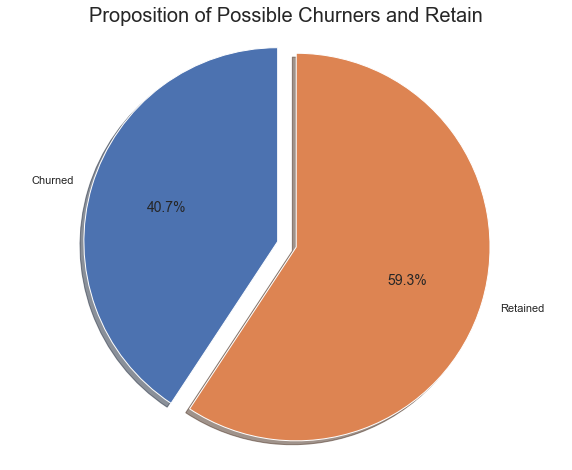

In [415]:
labels = 'Churned', 'Retained'
sizes = [Final.Churn_Flag[Final['Churn_Flag']==1].count(), Final.Churn_Flag[Final['Churn_Flag']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proposition of Possible Churners and Retain", size = 20)
plt.show()